# Processing Images and Videos
## Computer Vision and Image Processing - Lab Session 3
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Alex Costanzino, alex.costanzino@unibo.it - Iacopo Curti, iacopo.curti2@unibo.it

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Processing Images
Image processing plays a pivotal role in extracting valuable information from images, enhancing their quality, and enabling various forms of analysis.

Two fundamental categories of operators employed in image processing are point operators and local operators. 
These operators serve distinct purposes, with each being well-suited to specific types of image manipulation.

# Local Operators vs Point Operators

* **Local Operators**: take into account the spatial neighborhood of each pixel when performing operations by considering a defined region around each pixel and compute new values based on the characteristics of this local neighborhood;

* **Point Operators**: perform operations on individual pixels independently, without considering their surrounding context. These operations are applied uniformly across the entire image, with each pixel being processed based solely on its own intensity value.

<img src="LabSession3Images/point_vs_local.png" width="620">

# Point Operators

## Histogram

Point Operators are image processing operators aimed at enhancing the quality of the input image(e.g. the contrast).
Most of such operators **rely on the computation of the gray-level histogram (intensity histogram)** of the input image.
Loaded a **grayscale** image:

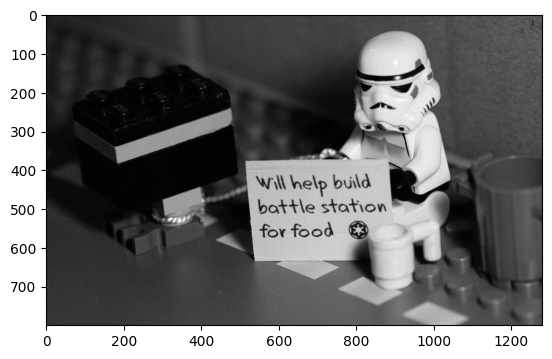

In [2]:
img = cv2.imread("LabSession3Images/image.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [3]:
print(img.shape)

(800, 1280)


we can compute its gray-level histogram using [`np.histogram(flat_image, bins=256, range=[0,256])`](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html).

Where:
* `flat_image`: image flattened to be a 1D array;
* `bins`: number of bins in the given range. If bins is an integer, the bounds are all numbers from minimum to maximum (exluded). Otherwise, they can be also a custom sequence.
* `range`: minimum and maximum values of our histograms.

**Why do we range from 0 to 256 if 8-bit images range from 0 to 255?**

Bins will have 257 elements since Numpy calculates bins as $0-0.99$, $1-1.99$, $2-2.99$, etc... 
So the final element's range would be $255-255.99$, with the last edge's value being 256, which however it is excluded... 

boh, qua l'hanno messa in maniera un po'strana. Puoi pensarla così: per distinguere 256 sottointervalli, hai bisogno di 257 muri

In [4]:
hist, bins = np.histogram(img.flatten(), 256, [0,256])
print("Histogram shape: ", hist.shape)
print("Bins shape: ", bins.shape)

Histogram shape:  (256,)
Bins shape:  (257,)


In [5]:
bins

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

Where __hist[i]__ are the number of pixels with the gray-scale value $i$. Bins are the indexes of each bin (i.e. numbers from 0 to 255)... quest'ultima frase è crazy

Let us see how many pixels have the value 20 in our image:

In [6]:
grayscale_value = 20
print(hist[grayscale_value])

3553


Let us plot the histogram:

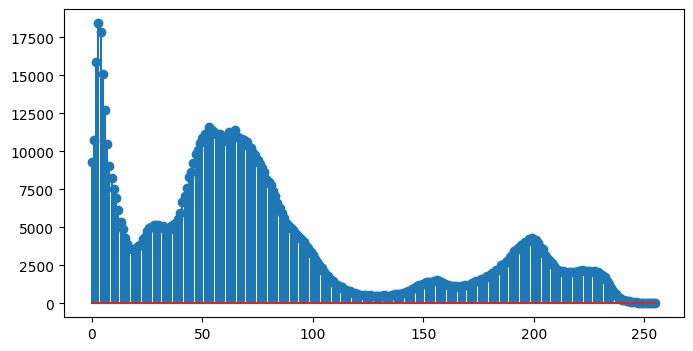

In [7]:
plt.figure(figsize=[8,4])
plt.stem(hist)
plt.show()

## Example of Point Operator: Linear Contrast Stretching

An image featuring a small gray-level range has likely poor contrast. The contrast can be enhanced by linearly stretching the intensities to span a larger interval (typically, the full available range).

Se l'immagine ha tutti i pixel appartenenti all'intervallo \[100, 180\], l’idea è ridistribuire linearmente questi valori in modo che:
- 100 diventi 0 (nero)
- 180 diventi 255 (bianco)
- Tutti i valori intermedi vengano riscalati proporzionalmente tra 0 e 255

Per ogni pixel con intensità originale p:

    p' = ((p - Pmin) / (Pmax - Pmin)) * (new_max - new_min) + new_min

Se vogliamo mappare al range completo 0–255:

    p' = ((p - Pmin) / (Pmax - Pmin)) * 255

dove:

- Pmin = valore minimo trovato nell’immagine  
- Pmax = valore massimo trovato nell’immagine  
- p'   = nuovo valore di intensità “stretchato”


Linear stretching at the full available range:

<img src="LabSession3Images/linear_stretch.png" width="320">
<img src="LabSession3Images/linear_stretching.png" width="480">

Nel grafico sopra, l'asse x rappresenta l'intensità originale mentre l'asse y l'intensità stretchata

Should most pixel lie in a small interval while there exist a few dark and bright outliers, the linear function would approximate the identity and thus be ineffective. In such a case, $P_{min}$ and $P_{max}$ can be taken equal to some percentiles of the distribution (e.g. 5% and 95%), with smaller and higher input intensities mapped to 0 and 255 respectively.

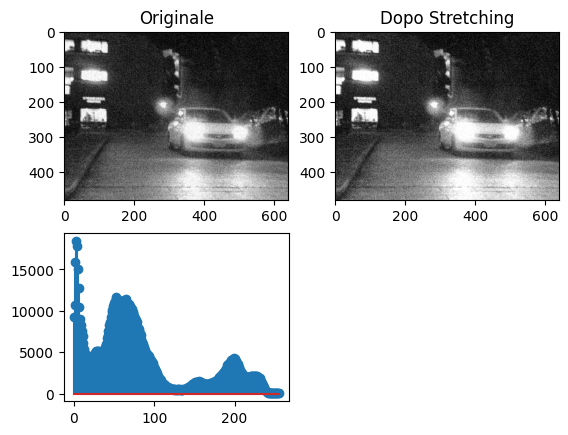

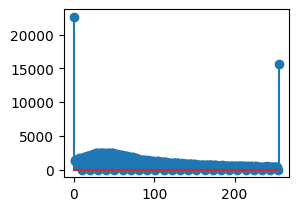

In [38]:
Pmin, Pmax = np.percentile(img, (5, 95))  # usa percentili per sicurezza
# Applica stretching lineare (invece di scorrere tutti i p, possiamo fare direttamente a livello di matrice)
# as-type mi converte l'array che ottengo dallo stretching in un array di interi (necessario per far si che sia un immagine)
# facendone una copia
# clip mi serve per valori che eccedono l'intervallo [0,255]
stretched = np.clip((img - Pmin) * 255 // (Pmax - Pmin), 0, 255)

plt.subplot(2, 2, 1)        # (righe, colonne, indice)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Originale')
plt.subplot(2, 2, 2)
plt.imshow(stretched, cmap='gray', vmin=0, vmax=255)
plt.title('Dopo Stretching')
hist_stretched, _ = np.histogram(stretched.flatten(), 256, [0,256])
plt.subplot(2, 2, 3)        # (righe, colonne, indice)
plt.stem(hist)
plt.show()
plt.subplot(2, 2, 4)        # (righe, colonne, indice)
plt.stem(hist_stretched)
plt.show()

## Local Operators: Convolutions and Correlations 

Local Operators compute the new intensity of a pixel, p, based on the intensities of those belonging to a neighbourhood of p.

<img src="LabSession3Images/local_op.png" width="320">

An important sub-class is given by the so called **Linear Translation-Equivariant** (LTE) operators.
LTE operators are defined **convolving** a kernel with an image.

However, we know that **convolutions and correlations** are the same if we have a **symmetric** kernel respect to the **origin**:

<img src="LabSession3Images/conv_corr.png" width="128">

Practically, local operator kernels are usually symmetric about the origin so usually we compute **correlations** instead of convolutions because they are **easier to implement**. In case we have not symmetric filter respect to the origin we can still use correlations but we need to first **flip the kernel**.

Given an image and a kernel (aka filter) in OpenCV we can perform a correlation with the following command:

<!-- **cv2.filter2D(image, -1, kernel, anchor)** -->
[`cv2.filter2D(image, -1, kernel, anchor)`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)

where **anchor** of the kernel indicates the relative position of a filtered point (nuovo pixel che stiamo computando) within the kernel; the anchor should lie within the kernel; default value (-1,-1) means that the **anchor** is at the kernel **center**.

<img src="LabSession3Images/anchor.png" width="128">

**anchor set (by default) at (-1,-1)**
     
<img src="LabSession3Images/anchor_top_left.png" width="128">

**anchor set at (0,0)**

If we need to compute a convolution we need to flip the kernel using:

<!-- **cv2.flip(kernel)** -->
[`cv2.flip(kernel)`](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#gaca7be533e3dac7feb70fc60635adf441)

In case of flip we need to set the new anchor to (kernel.cols - 1 - anchor.x, kernel.rows - 1 - anchor.y). -> mah, non mi sembra funzioni troppo



## Local Operators: Some Peculiar Filters

### Mean Filter 
In order to apply a mean filter of kernel size 9x9 to an image, it is possible to use the function:

<!-- **cv2.blur(image, dst, kernel_size, anchor, borderType)** -->
[`cv2.blur(image, kernel_size, anchor, borderType)`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37)

Parameters:

- **image**: It is the image, which is going to be blurred.

- **kernel_size**: A tuple representing the blurring kernel size.

- **anchor**: It is a variable of type integer representing anchor point and it’s default value Point is (-1, -1) which means that the anchor is at the kernel center (how???).

- **borderType**: It depicts what kind of border to be added. It is defined by flags like cv2.BORDER_CONSTANT, cv2.BORDER_REFLECT101 (default), etc


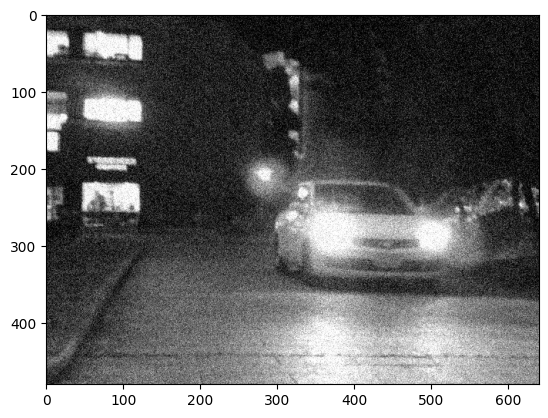

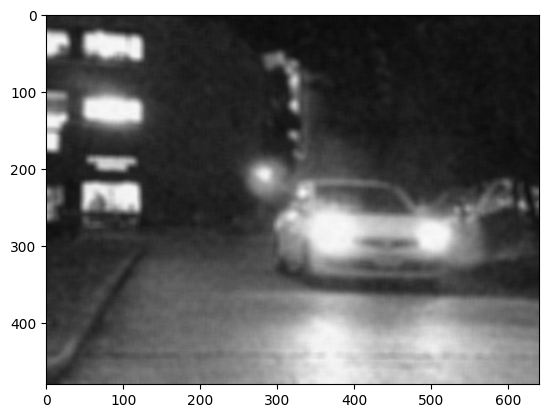

Time needed for filter2d implementation:  0.0035469350041239522


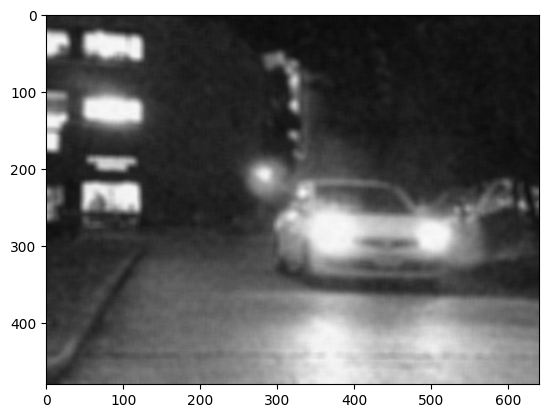

Time needed for blur command:  0.0005128379998495802


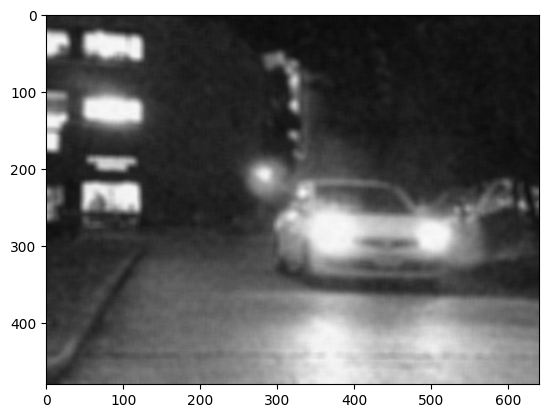

Time needed for boxFilter command:  0.0007082419979269616


In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

# Reading the image
img = cv2.imread("LabSession3Images/00010N_noisy.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray',vmin=0,vmax=255)
plt.show()

# mean filter manuale (filter2D)
k_size = 9
mean_kernel = np.ones([k_size,k_size])/(k_size**2)
start = time.perf_counter()
img_tr = cv2.filter2D(img,-1,mean_kernel)
t_exec=time.perf_counter()-start
plt.imshow(img_tr,cmap='gray',vmin=0,vmax=255)
plt.show()
print("Time needed for filter2d implementation: ", t_exec)


# Optimixed way to apply mean filter
start = time.perf_counter()
img_tr_optim = cv2.blur(img,(k_size,k_size))
t_exec=time.perf_counter()-start
plt.imshow(img_tr_optim,cmap='gray',vmin=0,vmax=255)
plt.show()
print("Time needed for blur command: ", t_exec)


# Another way to apply mean filter 
start = time.perf_counter()
img_tr_box_filter = cv2.boxFilter(img,-1,(k_size,k_size),normalize=True)
t_exec=time.perf_counter()-start
plt.imshow(img_tr_box_filter,cmap='gray',vmin=0,vmax=255)
plt.show()
print("Time needed for boxFilter command: ", t_exec)




### Gaussian filter
Gaussian filter is a special case of LTE operator where we sample from a 2D gaussian the values of our kernel.  

<img src="LabSession3Images/gaussian.png" width="320">

Given standard deviation $\sigma$ and kernel size we can obtain a 1D gaussian kernel in OpenCV with:

<!-- **gk = cv2.getGaussianKernel(kernel_size,sigma)** -->
[`gk = cv2.getGaussianKernel(kernel_size,sigma)`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa)

which 1D having shape $(KernelSize , 1)$

If we want a 2D gaussian filter with both $\sigma_x$ and $\sigma_y$ having the same value we can multiply the two 1D kernels with:

`gk_2D = gk.dot(gk.transpose())`

Otherwise, we can obtain the same result applying first the 1D gaussian kernel **gk** and then, applying its tranposed one **gk$^T$**.
- **Applying twice a 1D kernel instead of a 2D filter can be faster**, expecially in case of big kernels.

We can also use an high level API of OpenCV which given the kernel size and sigmas compute the gaussian filtering:

<!-- **gauss_out = cv2.GaussianBlur(image, (k_size,k_size) , sigma)** -->
[`gauss_out = cv2.GaussianBlur(image, (k_size,k_size), sigma)`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1)

In the following example we are going to aplly a 2D gaussian filter with $\sigma=1.5$ to an image, following the rule of thumb showed in the theory slides.

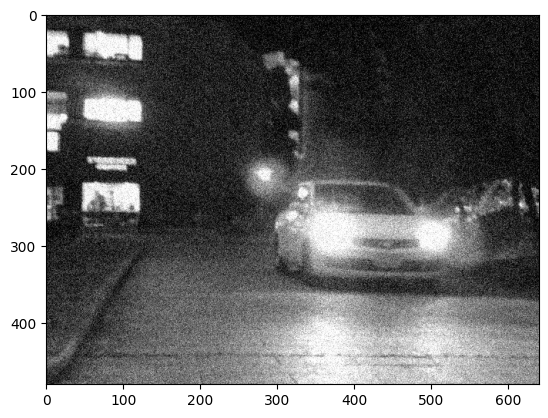

Sigma: 1.5, Kernel Size: 11
Time needed twice 1D:  0.001226177002536133


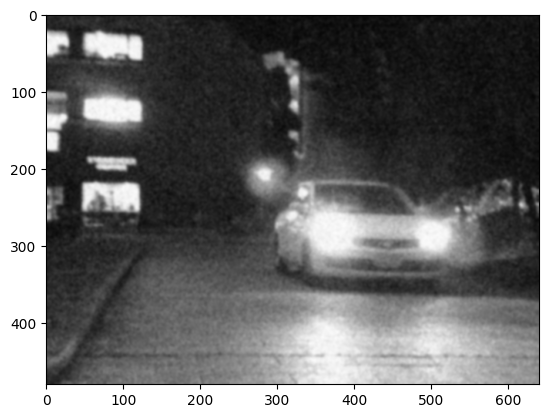

Time needed single 2D (SLOWER):  0.005229611997492611


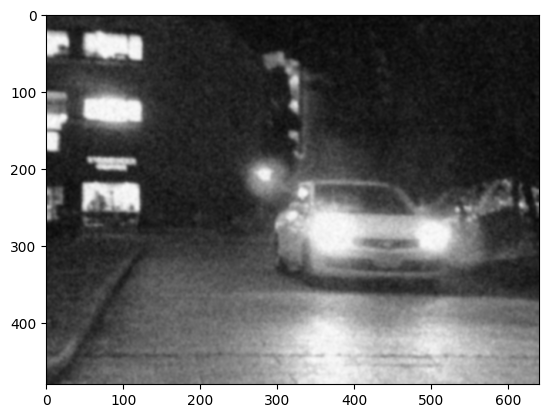

Time needed with OpenCV API (Best Optimization):  0.00305420200311346


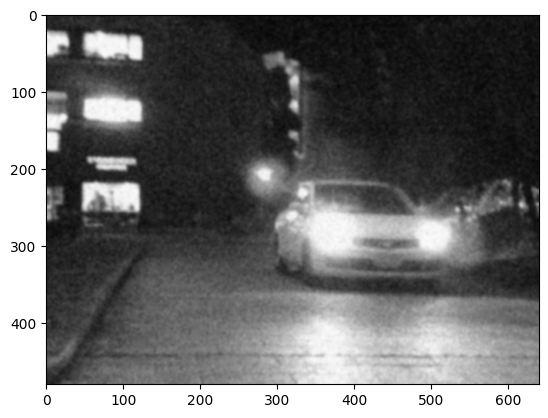

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time # Library to compute timings

# Reading the image
img = cv2.imread("LabSession3Images/00010N_noisy.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray',vmin=0,vmax=255)
plt.show()

# Higher sigmas should correspond to larger kernels.
sigma = 1.5
k_size = int(np.ceil((3*sigma))*2 + 1) #rule of thumb for a good kernel size given sigma
print("Sigma: {}, Kernel Size: {}".format(sigma, k_size))

# Finding the gaussian kernel 1D 11x1
gaussian_kernel_1D = cv2.getGaussianKernel(k_size, sigma)

start = time.perf_counter()
img_tr1 = cv2.filter2D(img,-1,gaussian_kernel_1D)
img_tr = cv2.filter2D(img_tr1,-1,gaussian_kernel_1D.transpose())
print("Time needed twice 1D: ", time.perf_counter()-start)
plt.imshow(img_tr,cmap='gray',vmin=0,vmax=255)
plt.show()

# Finding the gaussian kernel 2D 11x11
gaussian_kernel_2D = gaussian_kernel_1D.dot(gaussian_kernel_1D.transpose())

start = time.perf_counter()
# Applying the kernel
img_tr = cv2.filter2D(img,-1,gaussian_kernel_2D)
print("Time needed single 2D (SLOWER): ", time.perf_counter()-start)

# Plot the result
plt.imshow(img_tr,cmap='gray',vmin=0,vmax=255)
plt.show()

# Using OpenCV function GaussianBlur
start = time.perf_counter()
img_tr = cv2.GaussianBlur(img, (k_size,k_size) , sigma)
print("Time needed with OpenCV API (Best Optimization): ", time.perf_counter()-start)
# Plot the result
plt.imshow(img_tr,cmap='gray',vmin=0,vmax=255)
plt.show()



### Bilateral filter

<img src="LabSession3Images/bilateral.png" width="512">

Bilateral filter is highly effective at **noise removal** while **preserving edges**. 

The operation is **slower** compared to other filters. 

**Gaussian filters** is a function of **space** alone and does not consider whether pixels have almost the same intensity value or not resulting in blurred edges. 

On the other hand, the **bilateral filter** also uses a **Gaussian filter** in the **space** domain, but it also uses one more (multiplicative) **Gaussian filter** component which is a function of **pixel intensity differences**. 

- The Gaussian function of space makes sure that only pixels that are ‘spatial neighbors’ are considered for filtering
- while the Gaussian component applied in the intensity domain (a Gaussian function of intensity differences) ensures that only those pixels with intensities similar to that of the central pixel (‘intensity neighbors’) are included to compute the blurred intensity value. 

As a result, this method preserves edges, since for pixels lying near edges, neighboring pixels placed on the other side of the edge, and therefore exhibiting large intensity variations when compared to the central pixel, will not be included for blurring.

We can apply a bilateral filter in OpenCV with:

<!-- **cv2.bilateralFilter(image, filter_size, sigmaColor, sigmaSpace)**. -->
[`cv2.bilateralFilter(image, filter_size, sigmaColor, sigmaSpace)`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed).

Parameters:

- **image : Image which is going to be smoothened**
- **filter_size : Dimension of the kernel**
- **sigmaColor : Standard deviation that controls the influence of pixels with different intensity values**
- **sigmaSpace : Standard deviation that controls the influence of distant pixels**


In the following example we are going to apply a bilateral filter with filter size of 9x9 and both sigma values of 75. 

__N.B__:
* Sigma values: If they are small (< 10), the filter will not have much effect, whereas if they are large (> 150), they will have a very strong effect, making the image look “cartoonish”.
* Filter size: Large filters (> 5) are very slow, so it is recommended to use d=5 for real-time applications, and approximately 9 for offline applications that need heavy noise filtering.

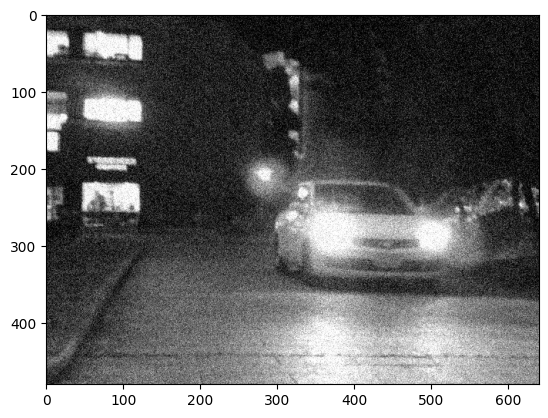

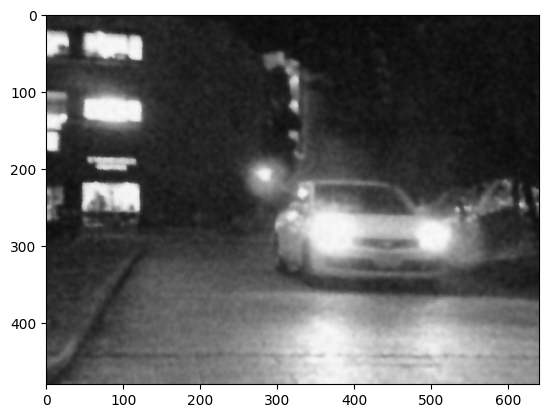

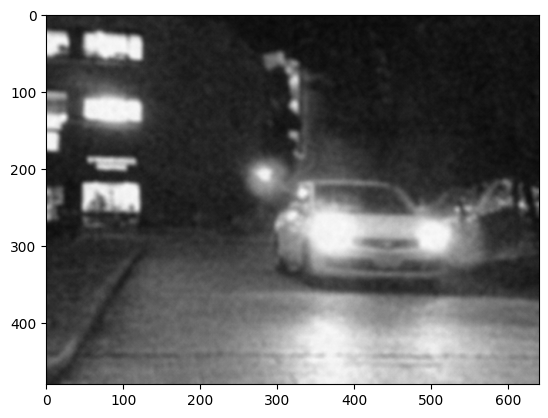

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Reading the image
img = cv2.imread("LabSession3Images/00010N_noisy.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray',vmin=0,vmax=255)
plt.show()

img_bilateral = cv2.bilateralFilter(img,9,75,75)
plt.imshow(img_bilateral,cmap='gray',vmin=0,vmax=255)
plt.show()

# non mi sembra molto "cartoonish"
img_bilateral = cv2.bilateralFilter(img,9,500,500)
plt.imshow(img_bilateral,cmap='gray',vmin=0,vmax=255)
plt.show()







# Processing Videos

A video is a temporal sequence of images, namely **Frames**.

<img src="LabSession3Images/Eadward-Muybridge-Horse-in-Motion.jpg" width="512">

The number of frames in 1 second of video is called **frame rate**

In a video we can elaborate each frame separately with processing algorithms or we can elaborate only keyframes of the original video and the missing ones are reconstructed by interpolation.

## Load a Video from File

To load a video in OpenCV you need to create a VideoCapture object. Its argument can be either the device index or the name of a video file.
A device index is just the number to specify which camera. Normally one camera will be connected (as in my case). So I simply pass 0 (or -1).
You can select the second camera by passing 1 and so on. After that, you can capture frame-by-frame. But at the end, don't forget to release the capture.

Let us now try to load a video from a file:



In [12]:
cap = cv2.VideoCapture('LabSession3Images/video.avi')

In [13]:
cap.isOpened()

True

Sometimes, cap may not have initialized the capture. In that case, this code shows an error. You can check whether it is initialized or not by the method `cap.isOpened()`. If it is True, OK. Otherwise open it using `cap.open()`.

In case the capture is open we can get a frame of the capture in the following way:

In [14]:
# Set the frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, 60) # stiamo impostando a 60 la posizione in frame nel video
if cap.isOpened():
    ret, frame = cap.read()

print(ret, frame.shape)

True (180, 320, 3)


Where _ret_ is a boolean variable which is True if we read the frame correctly and _frame_ is an image. Let us visualize the captured frame:

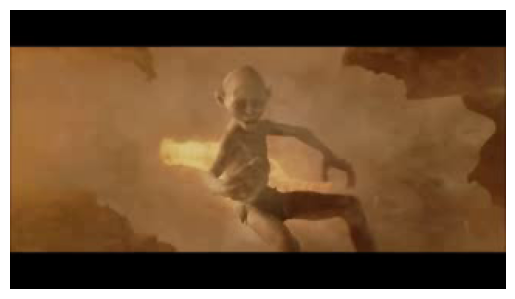

In [20]:
if ret and not frame is None:
    # Disabling matplotlib axis for better visualization
    plt.axis('off')
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

You can also access some of the features of this video using [`cap.get(propId)`](https://docs.opencv.org/3.4/d4/d15/group__videoio__flags__base.html#gaeb8dd9c89c10a5c63c139bf7c4f5704d) method where propId is a number from 0 to 18. Each number denotes a property of the video (if it is applicable to that video). Some of these values can be modified using cap.set(propId, value).

For example to get the width and height of the frame:

In [21]:
cv2.CAP_PROP_FRAME_WIDTH

3

In [22]:
print("Width: " , cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("Height: ", cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("FPS: ", cap.get(cv2.CAP_PROP_FPS))

Width:  0.0
Height:  0.0
FPS:  0.0


My video is of resolution 480x854.

To release the capture stream:

In [23]:
cap.release()

If we want to play our video in **jupyter notebook** we can do the following (a bit slow because of jupyter not being ideal for playing videos):

In [24]:
# Import additional library to properply play videos on jupyter notebook
from IPython.display import clear_output

# Put the code in try-except statements catch the keyboard exception and release the camera device and 
# continue with the rest of code.
def play_video(video_path):
    cap = cv2.VideoCapture(video_path)
    # Try-except statement to manage exceptions
    frame_count=0
    try:
        while(True):
            # Capture frame

            
            ret, frame = cap.read()
            frame_count += 1
            if frame_count % 4 != 0:
                continue
            if not ret or frame is None:
                # Release the Video if ret is false
                cap.release()
                print("Released Video Resource")
                # Break exit the for loops
                break
            
            # Display the frame
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.axis('off')
            plt.title("Input Stream")
            plt.imshow(frame)
            plt.show()
            
            # Clear cell output when new frame is available
            clear_output(wait=True)
    except KeyboardInterrupt:
        # If we press stop (jupyter GUI) release the video
        cap.release()
        print("Released Video Resource")

play_video('LabSession3Images/video.avi')

Released Video Resource


__N.B__: It can happen that we want to play a video from a non-jupyter enviroment. In that case we can modify the above code as follows:

```python
def play_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret or frame is None:
            # Release the Video if ret is false
            cap.release()
            print("Released Video Resource")
            break

        # !!! DISPLAYING CHANGE RESPECT TO JUPYTER VERSION !!!
        # Displaying with OpenCV (Not working in Jupyter)
        cv2.imshow('frame', frame)
        # Stop playing when entered 'q' from keyboard
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
```

## Load a Video from a Camera (Only if Camera Available)
If we want to load a video from a camera we can open our video capture giving a device id as input.

In [25]:
# Working only if a camera is available.
cap = cv2.VideoCapture(0)

print("Width: " , cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("Height: ", cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

Width:  640.0
Height:  480.0


Resolution is 640x480 by default. We can change it using cap.set (not all resolutions are possible depending on the camera driver):

In [26]:
ret = cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)

Now frames have the desired resolution:

In [27]:
if cap.isOpened():
    ret, frame = cap.read()

print(ret, frame.shape)

cap.release()

True (480, 640, 3)


Let us try to reproduce our webcam stream:

In [29]:
play_video(0)

Released Video Resource


## Saving a Video

To save a video on a file we need to create a VideoWriter object specifying:
* **Filename** (eg: output.avi)
* **FourCC code**: 4-byte code used to specify the video codec. The list of available codes can be found in fourcc.org. It is platform dependent. In Windows DIVX is the preferred choice while on linux we have several standards such as DIVX, XVID, X264 etc..
* **FPS**: number of frames per second
* **Frame size**
* Flag **isColor**: If it is True, the encoder expect color frame, otherwise it works with grayscale frame.

Let us try to load and save a video with each frame flipped along vertical axis. Load the original video:

In [33]:
# Loading Video
cap = cv2.VideoCapture("LabSession3Images/video.avi")

# Getting original video params
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

Initialize the VideoWriter based on the parameters of the original video:

In [34]:
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
# N.B. we need to specify the correct width and height of the frames otherwise we will not be able to reproduce the video
out = cv2.VideoWriter('output.avi', fourcc, fps, (w,  h))

Flip and save frame by frame the video:

In [35]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame is None:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frame = np.flip(frame, axis=0)
    # write the flipped frame
    out.write(frame)

Can't receive frame (stream end?). Exiting ...


Release the resources:

In [36]:
# Release everything if job is finished
cap.release()
out.release()

Let us visualize the flipped video:

In [37]:
play_video('output.avi')

Released Video Resource
